In [ ]:
# amazon dataset
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class AmazonReviewDataset(Dataset):
    def __init__(self, file_path):  
        self.data = pd.read_csv(file_path, sep='\t')  

    def __len__(self):  
        return len(self.data)

    def __getitem__(self, idx):  
        text = self.data.iloc[idx]['text']  
        label = self.data.iloc[idx]['label']  
        return text, label 

def load_amazon_reviews(file_path, batch_size):
    dataset = AmazonReviewDataset(file_path)  
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  
    return dataloader 

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [ ]:
# RNN
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):

        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

embed_size, num_hiddens, num_layers = 100, 100, 2
devices = d2l.try_all_gpus()

loss 0.294, train acc 0.876, test acc 0.854
636.0 examples/sec on [device(type='cuda', index=0)]


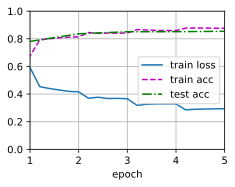

In [ ]:
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights)

glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
# embeds.shape
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

# evaluation
lr, num_epochs = 0.01, 5  
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.180, train acc 0.928, test acc 0.845
635.0 examples/sec on [device(type='cuda', index=0)]


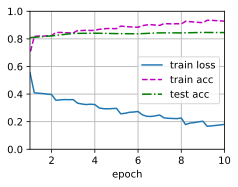

In [ ]:

lr, num_epochs = 0.01, 10 
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.112, train acc 0.958, test acc 0.848
639.5 examples/sec on [device(type='cuda', index=0)]


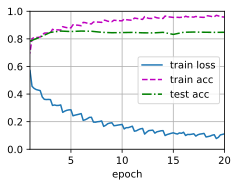

In [ ]:

lr, num_epochs = 0.01, 20  
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

&emsp;&emsp; Summary

| learning rate | epoch | result |
|:--:|:--:|:--:|
|0.01  | 5  | loss 0.294, train acc 0.876, test acc 0.854 |
|0.01  | 10 | loss 0.180, train acc 0.928, test acc 0.845 |
|0.01  | 20 | loss 0.112, train acc 0.958, test acc 0.848 |





In [ ]:
#torch 
import os
import torch
from torch import nn
from d2l import torch as d2l  


import torch
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")


batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size) 

In [ ]:
#get models
#@save
d2l.DATA_HUB['glove.6b.50d'] = (d2l.DATA_URL + 'glove.6B.50d.zip',
                                '0b8703943ccdb6eb788e6f091b8946e82231bc4d')

#@save
d2l.DATA_HUB['glove.6b.100d'] = (d2l.DATA_URL + 'glove.6B.100d.zip',
                                 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')

#@save
d2l.DATA_HUB['glove.42b.300d'] = (d2l.DATA_URL + 'glove.42B.300d.zip',
                                  'b5116e234e9eb9076672cfeabf5469f3eec904fa')

#@save
d2l.DATA_HUB['wiki.en'] = (d2l.DATA_URL + 'wiki.en.zip',
                           'c1816da3821ae9f43899be655002f6c723e91b88')


#@save
class TokenEmbedding:
    """ """
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = d2l.download_extract(embedding_name)
        with open(os.path.join(data_dir, 'vec.txt'), 'r',encoding='utf-8') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)


# 
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])


embed_size, num_hiddens, num_layers = 100, 100, 2
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.apply(init_weights)
devices = d2l.try_all_gpus()

In [3]:
glove_embedding_100 = TokenEmbedding('glove.6b.100d')

loss 0.415, train acc 0.816, test acc 0.820
2004.1 examples/sec on [device(type='cuda', index=0)]


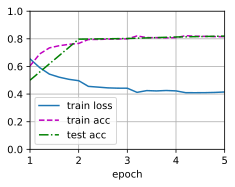

In [ ]:
embeds = glove_embedding_100[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False


lr, num_epochs = 0.01, 5
net.apply(init_weights)  
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)

In [ ]:
import os
import torch
from torch import nn
from d2l import torch as d2l


import spacy 
spacy_en = spacy.load("en_core_web_sm")


def tokenize(lines, token='word'):
    """Split text lines into word or character tokens.

    Defined in :numref:`sec_text_preprocessing`"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)


def tokenize1(text): 
    return [tok.text for tok in spacy_en.tokenizer("".join(text))]  # 在官方提供示例基础上，稍作修改


def tokenize2(lines, token='word'):
    if token == 'word':
        return [tokenize1(line) for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

In [ ]:

doc = ["This is a sentence.","df","df df"]
train_tokens = d2l.tokenize(doc, token='word')
print(train_tokens)
train_tokens = tokenize2(doc, token='word')  
print(train_tokens)

In [15]:
def load_data_imdb(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset.

    Defined in :numref:`sec_sentiment`"""
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = d2l.read_imdb(data_dir, True)
    test_data = d2l.read_imdb(data_dir, False)
    train_tokens = tokenize2(train_data[0], token='word')
    test_tokens = tokenize2(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

In [ ]:
batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size) 

In [18]:
glove_embedding_100 = TokenEmbedding('glove.6b.100d')

loss 0.254, train acc 0.897, test acc 0.868
2037.0 examples/sec on [device(type='cuda', index=0)]


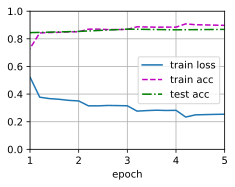

In [ ]:
embeds = glove_embedding_100[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False


lr, num_epochs = 0.01, 5
net.apply(init_weights) 
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [ ]:
# CNN
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        embeddings = embeddings.permute(0, 2, 1)
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

loss 0.068, train acc 0.978, test acc 0.868
2366.1 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


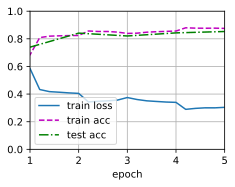

In [ ]:

embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.008, train acc 0.998, test acc 0.863
2831.7 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


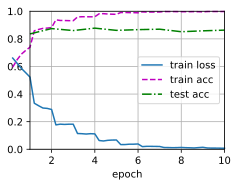

In [ ]:


lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.006, train acc 0.998, test acc 0.854
2839.8 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


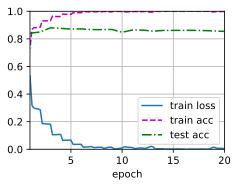

In [ ]:

lr, num_epochs = 0.001, 20
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

 row| tokenize | GloVe dimension | learning rate | epoch |  result |
 :-----: |---------:| :----: | :----: | :----: | :----: |
 1|  default | 100 | 0.01 | 5 | loss 0.031, train acc 0.989, test acc 0.857 |
 2| default |      300 | 0.01 | 5 | loss 0.046, train acc 0.984, test acc 0.857 |
 3| default |      100 | 0.01 | 10 | loss 0.022, train acc 0.993, test acc 0.850 |
 4| default |      100 | 0.001 | 5 | loss 0.075, train acc 0.976, test acc 0.870 |
 5| default |      100 | 0.001 | 10 | loss 0.008, train acc 0.998, test acc 0.866 |
 6| spaCy |      100 | 0.01 | 5 | loss 0.054, train acc 0.982, test acc 0.854 |
 7| spaCy |      100 | 0.001 | 5 | loss 0.113, train acc 0.961, test acc 0.877 |

In [14]:
import torch
from torch import nn
from d2l import torch as d2l
import math

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

loss 0.224, train acc 0.916, test acc 0.873
2829.7 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


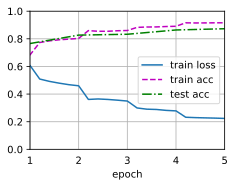

In [ ]:

embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);


glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False


lr, num_epochs = 0.0003, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.028, train acc 0.991, test acc 0.863
2838.6 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


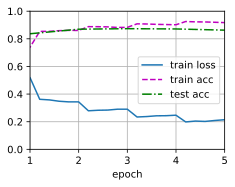

In [ ]:
lr, num_epochs = 0.003, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [ ]:

def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        f_A = self.f(A)
        f_B = self.f(B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B
    

class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

In [ ]:

class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

loss 0.495, train acc 0.806, test acc 0.826
14133.1 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


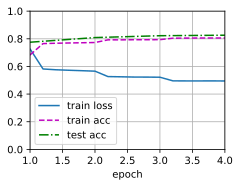

In [ ]:

batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.441, train acc 0.830, test acc 0.834
14859.5 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


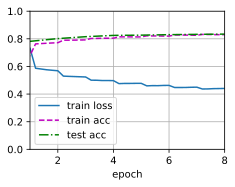

In [ ]:
lr, num_epochs = 0.001, 8
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.440, train acc 0.829, test acc 0.834
22247.6 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


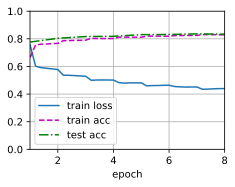

In [ ]:
lr, num_epochs = 0.001, 8
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)